In [1]:
!nvidia-smi

Tue Jul  6 06:44:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install kornia
!pip install lpips
!pip install git+https://github.com/ChristophReich1996/Involution

  Cloning https://github.com/ChristophReich1996/Involution to /tmp/pip-req-build-ts08923h
  Running command git clone -q https://github.com/ChristophReich1996/Involution /tmp/pip-req-build-ts08923h
  Created wheel for involution: filename=involution-0.2-cp37-none-any.whl size=4732 sha256=db757657fc1f2ba8c96cabd5182fbebd7e6b18dd364193e361772516852c5418
  Stored in directory: /tmp/pip-ephem-wheel-cache-ac_jyo22/wheels/d2/b3/9b/ef9398d783f0609e8ddca4cd465f7840d074741ba5c4f7fae4
Successfully built involution


In [3]:
# Import necessary libraries

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torchvision import datasets, transforms
from torch.optim import *

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import cv2
import glob
import copy

from sklearn.model_selection import train_test_split
#import wandb

from torchsummary import summary

from skimage.feature import hog
from tqdm import tqdm as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42

from numba import jit, cuda

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset

from PIL import Image
import glob

import albumentations as A
from albumentations.pytorch import ToTensor

# https://kornia.readthedocs.io/en/latest/losses.html
from kornia.losses import ssim, psnr, ssim_loss, psnr_loss
import lpips

import torch
from involution import Involution2d

#involution = Involution2d(in_channels=32, out_channels=64)
#output = involution(torch.rand(1, 32, 128, 128))

/usr/local/lib/python3.7/dist-packages/kornia/augmentation/augmentation.py:1875: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


In [4]:
# Mount google drive to colab

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!ls -lrt /content/drive/MyDrive/CV_Project/Dataset

total 5406435
-rw------- 1 root root  434661527 May  9 17:48 SOTS.zip
-rw------- 1 root root    7160851 May  9 17:49 HSTS.zip
-rw------- 1 root root 5094361262 May  9 20:07 archive.zip
drwx------ 2 root root       4096 May 14 08:36 SOTS


In [6]:
!cp /content/drive/MyDrive/CV_Project/Dataset/SOTS.zip ./

!mkdir RESIDE
!cp /content/drive/MyDrive/CV_Project/Dataset/archive.zip ./RESIDE/

In [7]:
%cd /content/
!unzip -qq SOTS.zip

/content


In [8]:
%cd /content/RESIDE
!unzip -qq archive.zip

/content/RESIDE


In [9]:
%cd /content/
!ls -lrt ./RESIDE

/content
total 4976624
-rw-r--r-- 1 root root     672203 Oct 24  2020 metadata.csv
-rw------- 1 root root 5094361262 Jul  6 06:47 archive.zip
drwxr-xr-x 2 root root      36864 Jul  6 06:47 clear
drwxr-xr-x 2 root root     532480 Jul  6 06:48 hazy
drwxr-xr-x 2 root root     442368 Jul  6 06:48 trans


In [10]:
!ls -lrt ./SOTS/indoor/

total 24
drwxr-xr-x 2 root root 20480 Nov 12  2017 hazy
drwxr-xr-x 2 root root  4096 Jan 22  2018 gt


In [11]:
!ls -lrt ./SOTS/

total 8
drwxr-xr-x 4 root root 4096 Jan 22  2018 outdoor
drwxr-xr-x 4 root root 4096 Jan 22  2018 indoor


In [12]:
!ls -lrt /content/SOTS/outdoor/

!rm -rf /content/SOTS/outdoor/hazy/0051_0.95_0.12.jpg
!rm -rf /content/SOTS/outdoor/hazy/0076_1_0.16.jpg
!rm -rf /content/SOTS/outdoor/hazy/0086_0.95_0.12.jpg
!rm -rf /content/SOTS/outdoor/hazy/0108_1_0.2.jpg
!rm -rf /content/SOTS/outdoor/hazy/0253_1_0.16.jpg
!rm -rf /content/SOTS/outdoor/hazy/0287_0.95_0.08.jpg
!rm -rf /content/SOTS/outdoor/hazy/0330_0.8_0.08.jpg
!rm -rf /content/SOTS/outdoor/hazy/0320_0.9_0.08.jpg

total 32
drwxr-xr-x 2 root root 20480 Dec 23  2017 hazy
drwxr-xr-x 2 root root 12288 Dec 23  2017 gt


In [13]:
!ls -lrt

total 424496
drwxr-xr-x 4 root root      4096 Jan 22  2018 SOTS
drwxr-xr-x 1 root root      4096 Jun 15 13:37 sample_data
drwx------ 6 root root      4096 Jul  6 06:44 drive
-rw------- 1 root root 434661527 Jul  6 06:45 SOTS.zip
drwxr-xr-x 5 root root      4096 Jul  6 06:48 RESIDE


In [14]:
class RESIDEDataset(Dataset):
    def __init__(self, path, train = True, transform=None):
        self.path = path
        self.transform = transform
        self.train = train
        if self.train:
          self.images_hazy = sorted([file for file in glob.glob(self.path + 'hazy/' + '*')])
          self.images_clear = sorted([file for file in glob.glob(self.path + 'clear/' + '*')])
          self.clear_base_path = self.path + 'clear/'
        else:
          self.images_hazy = sorted([file for file in glob.glob(self.path + 'hazy/' + '*')])
          self.images_clear = sorted([file for file in glob.glob(self.path + 'gt/' + '*')])
          self.clear_base_path = self.path + 'gt/'

            
    def __getitem__(self,index):
        image_hazy_path = self.images_hazy[index]
        #hazy = Image.open(image_hazy_path)
        hazy = cv2.imread(image_hazy_path)
        hazy = cv2.cvtColor(hazy, cv2.COLOR_BGR2RGB)

        #print(image_hazy_path)
        clear_hazy_path = self.clear_base_path + image_hazy_path.split('/')[-1].split('_')[0] + '.png'
        #print(clear_hazy_path)
        #clear = Image.open(clear_hazy_path)
        clear = cv2.imread(clear_hazy_path)
        clear = cv2.cvtColor(clear, cv2.COLOR_BGR2RGB)


        if self.transform:
            transformed = self.transform(image=hazy, mask=clear)
            hazy_transformed = transformed['image']
            clear_transformed = torch.squeeze(transformed['mask']).permute(2,0,1)

        return hazy_transformed, clear_transformed
        
    def __len__(self):
        return len(self.images_hazy)

In [15]:
batch_size = 64

In [16]:
train_transform = A.Compose(
    [
        #A.CenterCrop(height=224, width=224),
        #A.RandomCrop(height=224, width=224),
        A.Resize(height=128, width=128),
        A.HorizontalFlip(),
        A.Rotate(30),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Normalize(mean=(0.64, 0.6, 0.58),std=(0.14,0.15, 0.152)),
        ToTensor(),
    ])

test_transform = A.Compose(
    [
        #A.CenterCrop(height=224, width=224),
        A.Resize(height=128, width=128),
        A.Normalize(mean=(0.64, 0.6, 0.58),std=(0.14,0.15, 0.152)),
        ToTensor(),
    ])

In [17]:
#train_transform = transforms.Compose([transforms.CenterCrop((224,224)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(30), transforms.ToTensor(),])
#test_transform = transforms.Compose([transforms.CenterCrop((224,224)), transforms.ToTensor(),])

In [18]:
trainset = RESIDEDataset(path = '/content/RESIDE/', train = True, transform = train_transform)
testset_id = RESIDEDataset(path = '/content/SOTS/indoor/', train = False, transform = test_transform)
testset_od = RESIDEDataset(path = '/content/SOTS/outdoor/', train = False, transform = test_transform)

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_id = torch.utils.data.DataLoader(testset_id, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_od = torch.utils.data.DataLoader(testset_od, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
#%%time
dataiter = iter(trainloader)
images, masks = dataiter.next()

print(type(images))
print(type(masks))
print(images.shape)
print(masks.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


In [21]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization
### loss_fn_vgg, appears crashing with batch_size of 256

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [22]:
d = loss_fn_alex(images, masks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
torch.mean(d)

tensor(0.3152, grad_fn=<MeanBackward0>)

In [24]:
images[0].shape

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


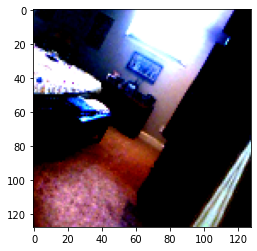

In [25]:
plt.imshow(images[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

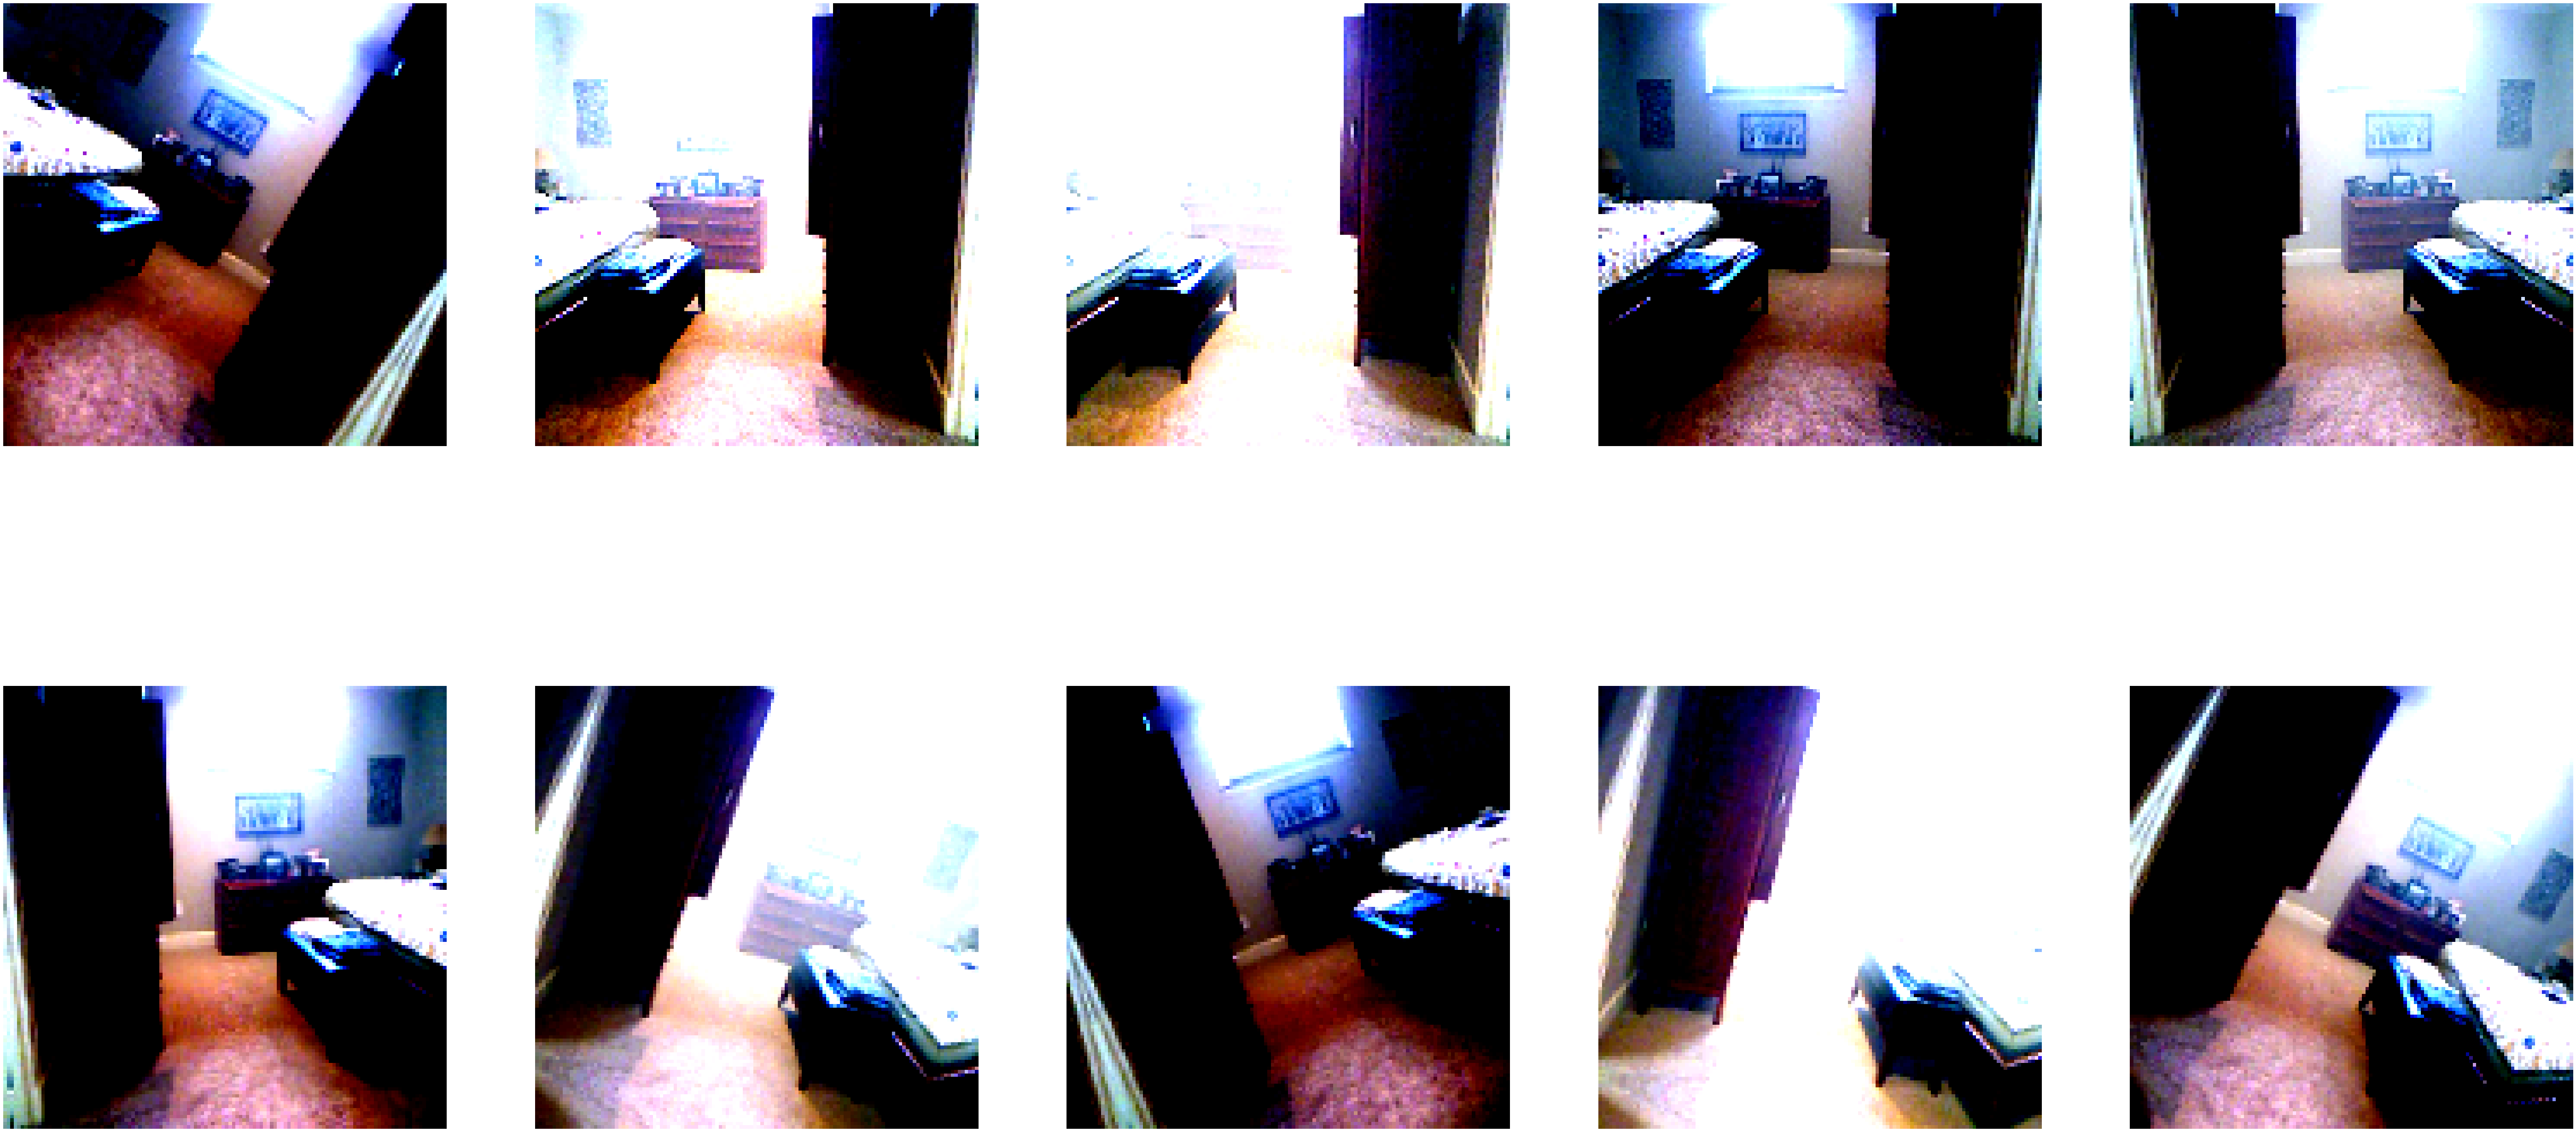

In [26]:
# Display 10 Hazy Images

figure = plt.figure()
num_of_images = 10
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().transpose(1, 2, 0))

<Figure size 432x288 with 0 Axes>

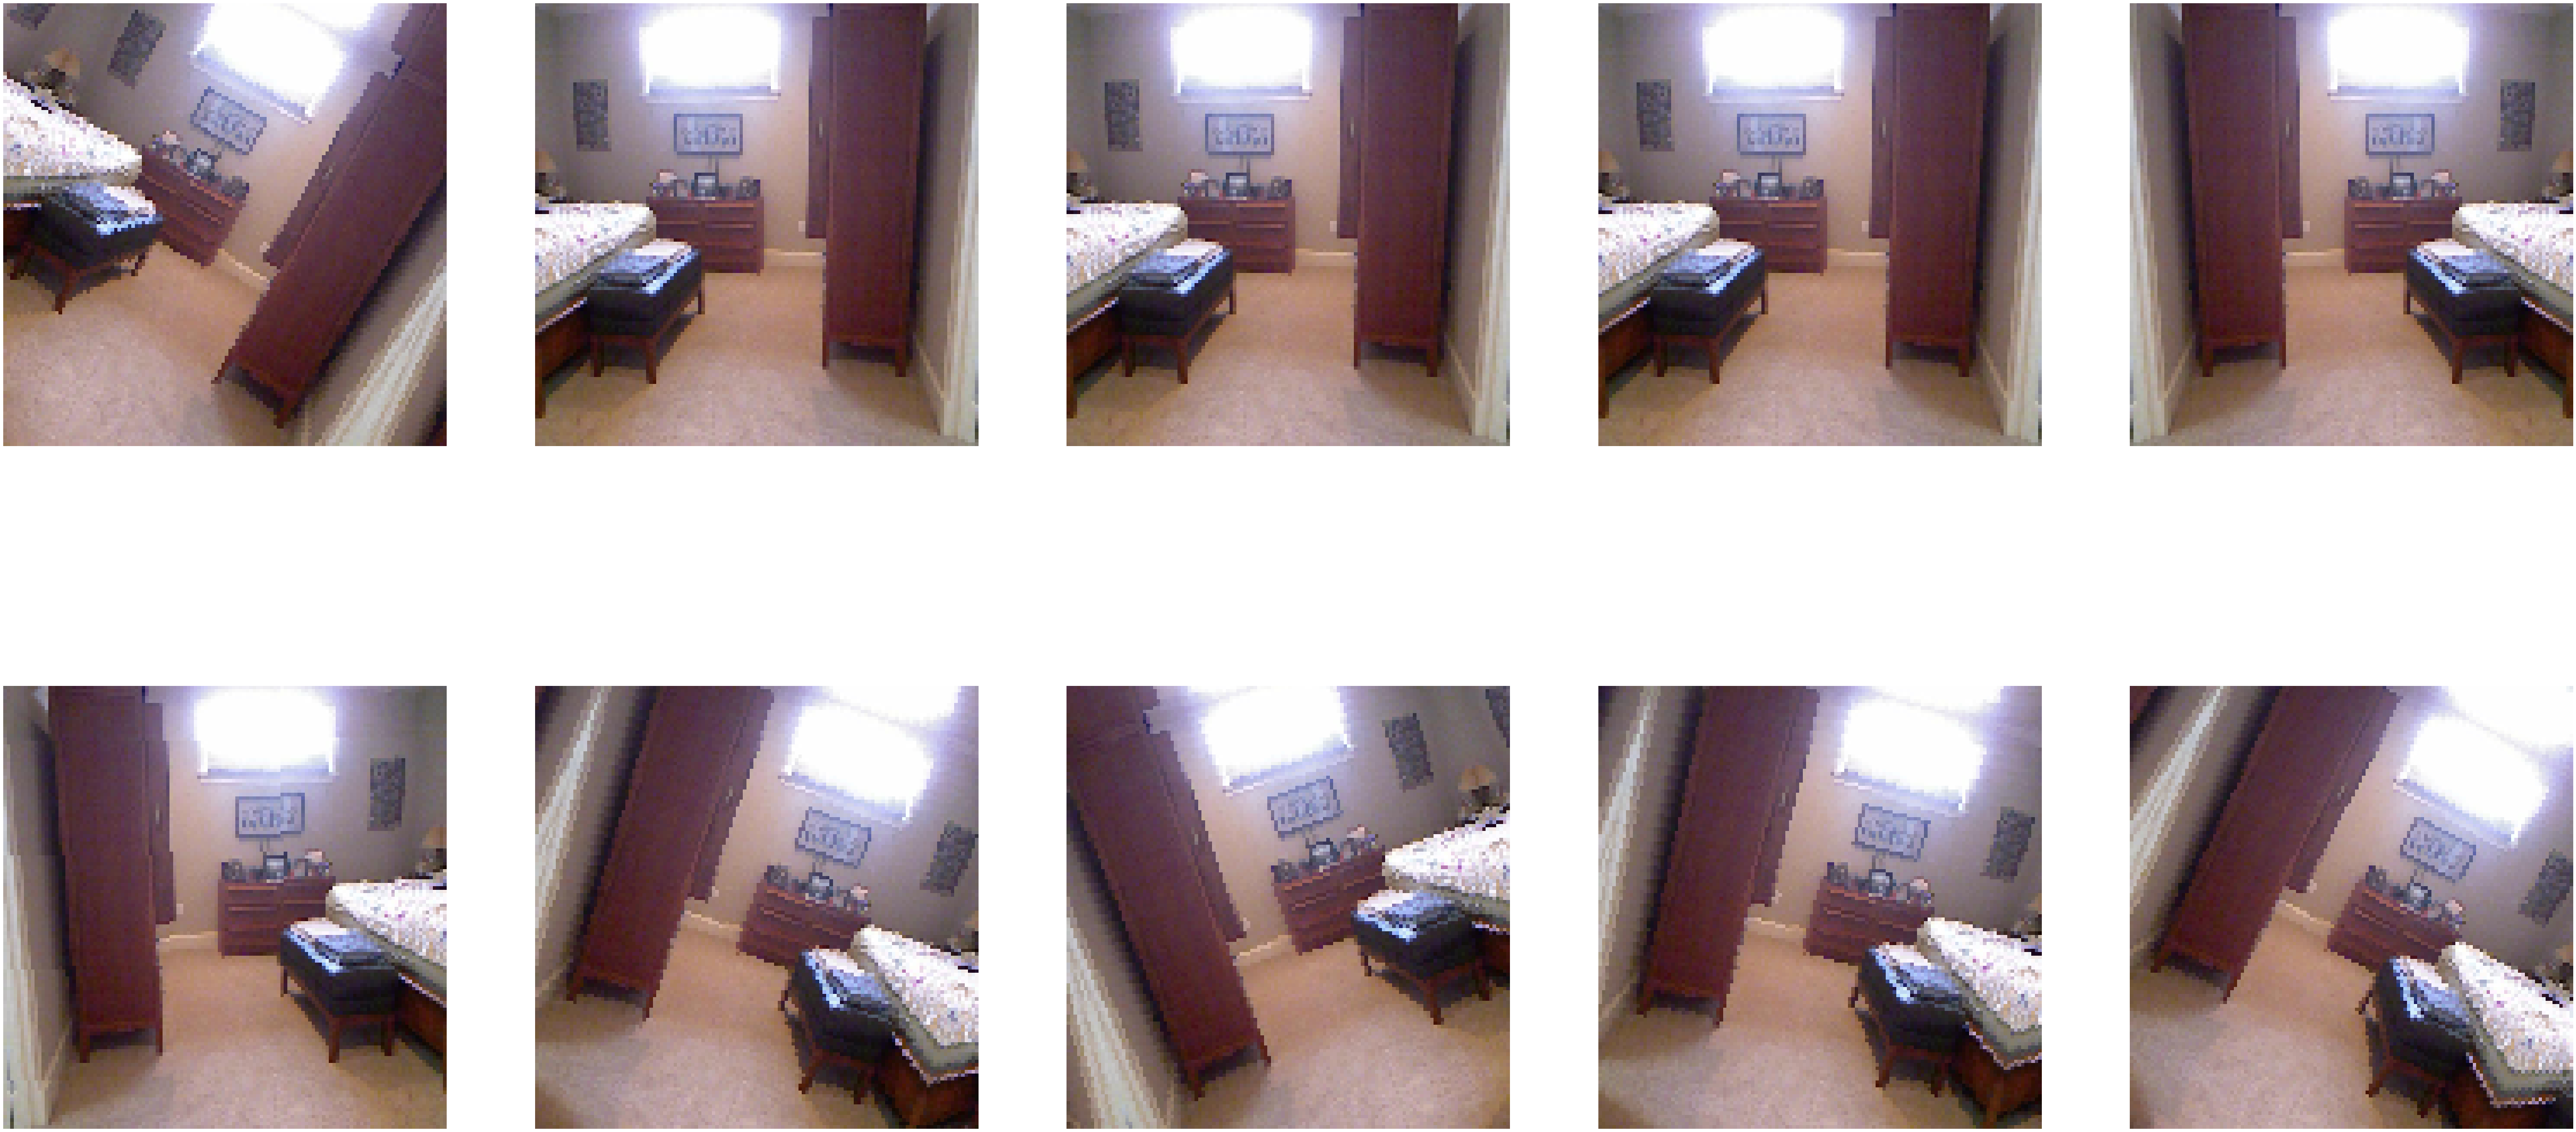

In [27]:
# Display 10 corresponding Clear Images

figure = plt.figure()
num_of_images = 10
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(masks[index].numpy().transpose(1, 2, 0))

In [28]:
def train_epoch(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.
    psnr_score_running = 0.
    ssim_score_running = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    #true_labels = []
    #pred_labels = []


    for batch_idx, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        model = model.to(device)
        optimizer.zero_grad()
        pred_masks = model(inputs)
        #print(pred_masks.is_cuda)
        #print(labels.is_cuda)
        loss_fn_alex = lpips.LPIPS(net='alex', verbose = False).cuda()  ### AlexNet perpetual loss
        loss_dist = loss_fn_alex(labels, pred_masks)
        ssim_loss_batch = ssim_loss(labels, pred_masks, 11) ## Include in composite loss
        psnr_loss_batch = psnr_loss(labels, pred_masks, 1) ## Include in composite loss
        composite_loss = 0.6 * loss_dist + 0.1 * ssim_loss_batch + 0.3 * psnr_loss_batch
        #composite_loss = loss_dist
        #loss = torch.mean(loss_dist)
        loss = torch.mean(composite_loss)


        '''
        smooth = 1e-6
        intersection = (outputs * labels).sum()                            
        dice = (2.*intersection + smooth)/(outputs.sum() + labels.sum() + smooth) 

        bce_loss = criterion(outputs, labels)


        total = (outputs + labels).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)

        loss = 1 - dice + bce_loss
        '''

        #pred_mask = outputs

        #true_labels.append(labels)
        #pred_labels.append(pred_masks)

        loss.backward()
        optimizer.step()

        ####print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()

        ssim_score = torch.mean(ssim(labels, pred_masks, 11))
        psnr_score = psnr(labels, pred_masks, 1)
  
        ssim_score_running += ssim_score.detach().cpu().item()*len(labels)
        psnr_score_running += psnr_score.detach().cpu().item()*len(labels)

        batch_num += 1
        samples_num += len(labels)
    #print(f1_running / samples_num)
    return epoch_loss / batch_num, ssim_score_running / samples_num, psnr_score_running/ samples_num
    #return

In [29]:
def test_epoch(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()

    epoch_loss = 0.
    #epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    psnr_score_running = 0.
    ssim_score_running = 0.
    
    #true_labels = []
    #pred_labels = []

    with torch.no_grad():
      for batch_idx, data in  enumerate(testloader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        model = model.to(device)
        pred_masks = model(inputs)
        loss_fn_alex = lpips.LPIPS(net='alex', verbose = False).cuda()  ### AlexNet perpetual loss
        loss_dist = loss_fn_alex(labels, pred_masks)
        ssim_loss_batch = ssim_loss(labels, pred_masks, 11) ## Include in composite loss
        psnr_loss_batch = psnr_loss(labels, pred_masks, 1) ## Include in composite loss
        composite_loss = 0.6 * loss_dist + 0.1 * ssim_loss_batch + 0.3 * psnr_loss_batch
        #composite_loss = loss_dist
        #loss = torch.mean(loss_dist)
        loss = torch.mean(composite_loss)

        ####print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()

        ssim_score = torch.mean(ssim(labels, pred_masks, 11))
        psnr_score = psnr(labels, pred_masks, 1)
  
        ssim_score_running += ssim_score.detach().cpu().item()*len(labels)
        psnr_score_running += psnr_score.detach().cpu().item()*len(labels)
        
        batch_num += 1
        samples_num += len(labels)
      return epoch_loss / batch_num, ssim_score_running / samples_num, psnr_score_running/ samples_num

In [30]:
def train_model(model, train_loader, test_loader_id, test_loader_od, criterion, optimizer, lr_scheduler, epochs):
    train_losses = []
    train_ssims = []
    train_psnrs = []
    test_losses_id = []
    test_ssims_id = []
    test_psnrs_id = []
    test_losses_od = []
    test_ssims_od = []
    test_psnrs_od = []
    best_loss = 0
    best_model = None

    for epoch in range(epochs):
        print('='*15, f'Epoch: {epoch}')
    

        train_loss, train_ssim, train_psnr = train_epoch(model, train_loader, criterion, optimizer, lr_scheduler, phase='train')

        test_loss_id, test_ssim_id, test_psnr_id = test_epoch(model, test_loader_id, criterion, optimizer, lr_scheduler, phase='test')

        test_loss_od, test_ssim_od, test_psnr_od = test_epoch(model, test_loader_od, criterion, optimizer, lr_scheduler, phase='test') 

        #testloader_id

        #lr_scheduler.step()
        print()
        print(f'Train loss: {train_loss}, Train SSIM: {train_ssim}, Train PSNR: {train_psnr}')
        print(f'Test loss SOTS Indoor: {test_loss_id}, Test SSIM SOTS Indoor: {test_ssim_id}, Test PSNR SOTS Indoor: {test_psnr_id}')
        print(f'Test loss SOTS Outdoor: {test_loss_od}, Test SSIM SOTS Outdoor: {test_ssim_od}, Test PSNR SOTS Outdoor: {test_psnr_od}')
        print()
    
        train_losses.append(train_loss)
        train_ssims.append(train_ssim)
        train_psnrs.append(train_psnr)
        test_losses_id.append(test_loss_id)
        test_ssims_id.append(test_ssim_id)
        test_psnrs_id.append(test_psnr_id)
        test_losses_od.append(test_loss_od)
        test_ssims_od.append(test_ssim_od)
        test_psnrs_od.append(test_psnr_od)
    
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'/content/drive/MyDrive/CV_Project/CheckPoints_U/r3/unet-{epoch}.pt')
        '''
        if best_model is None or test_loss < best_loss:
            best_model = copy.deepcopy(model)
            best_loss = test_loss
            #best_test_acc = test_dice
            #best_pred_labels = pred_labels
            torch.save({'epoch': epoch, 'model': model.state_dict()}, f'nn-{seed}.pt')
        '''
    return train_losses,train_ssims,train_psnrs,test_losses_id,test_ssims_id,test_psnrs_id,test_losses_od,test_ssims_od,test_psnrs_od

In [31]:
class Block_en(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.inonv1 = Involution2d(in_channels=in_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.inonv2 = Involution2d(in_channels=out_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))
    
    def forward(self, x):
        #return self.relu(self.conv2(self.relu(self.conv1(x))))
        #print(self.inonv1(x).shape)
        return self.relu(self.conv2(self.relu(self.inonv1(x))))
        #return self.relu(self.inonv2(self.relu(self.inonv1(x))))

In [32]:
class Block_de(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        #self.inonv1 = Involution2d(in_channels=in_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        #self.inonv2 = Involution2d(in_channels=out_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
        #print(self.inonv1(x).shape)
        #return self.relu(self.conv2(self.relu(self.inonv1(x))))

In [33]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block_en(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [34]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block_de(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [35]:
class InvolutionUNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512), dec_chs=(512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out


In [36]:
model_unet = InvolutionUNet(enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=3, retain_dim=False, out_sz=(128,128))

In [37]:
summary(model_unet.cuda(), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             192
            Unfold-2           [-1, 576, 16384]               0
         AvgPool2d-3          [-1, 3, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]             192
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 9, 128, 128]             576
      Involution2d-8         [-1, 64, 128, 128]               0
              ReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,928
             ReLU-11         [-1, 64, 128, 128]               0
         Block_en-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

In [38]:
input = torch.randn((1,3,64,64), requires_grad=True)

In [39]:
output = model_unet(input.cuda())

In [40]:
output.shape

torch.Size([1, 3, 64, 64])

In [41]:
##criterion = nn.BCELoss()
criterion = None ## Since loss is hard-coded in the train function
optimizer = torch.optim.SGD(model_unet.parameters(), lr=1e-2, weight_decay=0.01, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

#optimizer = torch.optim.SGD(model_unet.parameters(), lr=1e-2, weight_decay=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4)
#lr_scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0, last_epoch=-1, verbose=False)

#lr_scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1, verbose=False)
#lr_scheduler =  torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=1,step_size_up=100,mode="exp_range",gamma=0.85)

#lr_scheduler =  torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=10, epochs=10, verbose=True)

In [41]:
epochs = 15

train_losses,train_ssims,train_psnrs,test_losses_id,test_ssims_id,test_psnrs_id,test_losses_od,test_ssims_od,test_psnrs_od = train_model(model_unet, trainloader, testloader_id, testloader_od, criterion, optimizer, lr_scheduler, epochs)

=============== Epoch: 0

Train loss: -3.567133884587789, Train SSIM: 0.4030029154573704, Train PSNR: 12.906850334369258
Test loss SOTS Indoor: -4.398297965526581, Test SSIM SOTS Indoor: 0.5426793971061706, Test PSNR SOTS Indoor: 15.191171203613282
Test loss SOTS Outdoor: -4.303823113441467, Test SSIM SOTS Outdoor: 0.5346133117753316, Test PSNR SOTS Outdoor: 15.052829913007535

=============== Epoch: 1

Train loss: -4.149295801441419, Train SSIM: 0.4975394645020142, Train PSNR: 14.479670918609859
Test loss SOTS Indoor: -4.515864044427872, Test SSIM SOTS Indoor: 0.5564899306297302, Test PSNR SOTS Indoor: 15.51696923828125
Test loss SOTS Outdoor: -3.9240105152130127, Test SSIM SOTS Outdoor: 0.4904207892534209, Test PSNR SOTS Outdoor: 13.810403839359438

=============== Epoch: 2

Train loss: -4.2758666881143235, Train SSIM: 0.5192395742490004, Train PSNR: 14.827192110739238
Test loss SOTS Indoor: -4.233189105987549, Test SSIM SOTS Indoor: 0.5546752710342407, Test PSNR SOTS Indoor: 14.5944

## Inference on the Best Model 

In [42]:
test_transform_display = A.Compose(
    [
        #A.CenterCrop(height=224, width=224),
        A.Resize(height=128, width=128),
        #A.Normalize(mean=(0.64, 0.6, 0.58),std=(0.14,0.15, 0.152)),
        ToTensor(),
    ])

In [43]:
testset_id_display = RESIDEDataset(path = '/content/SOTS/indoor/', train = False, transform = test_transform_display)
testset_od_display = RESIDEDataset(path = '/content/SOTS/outdoor/', train = False, transform = test_transform_display)

In [44]:
testloader_id_display = torch.utils.data.DataLoader(testset_id_display, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_od_display = torch.utils.data.DataLoader(testset_od_display, batch_size=batch_size, shuffle=False, num_workers=2)

In [60]:
best_model = InvolutionUNet(enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=3, retain_dim=False, out_sz=(128,128))

best_ckp = torch.load('/content/drive/MyDrive/CV_Project/CheckPoints_U/r3/unet-14.pt')

best_model.load_state_dict(best_ckp['model'])

<All keys matched successfully>

### SOTS Indoor

In [61]:
test_loss_id, test_ssim_id, test_psnr_id = test_epoch(best_model, testloader_id, criterion, optimizer, lr_scheduler, phase='test')
print()
print(f'Test loss SOTS Indoor: {test_loss_id}, Test SSIM SOTS Indoor: {test_ssim_id}, Test PSNR SOTS Indoor: {test_psnr_id}')
print()


Test loss SOTS Indoor: -4.94312596321106, Test SSIM SOTS Indoor: 0.6073142466545105, Test PSNR SOTS Indoor: 16.847265625



In [62]:
dataiter = iter(testloader_id_display)
images_did, masks_did = dataiter.next()

print(type(images_did))
print(type(masks_did))
print(images_did.shape)
print(masks_did.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


<Figure size 432x288 with 0 Axes>

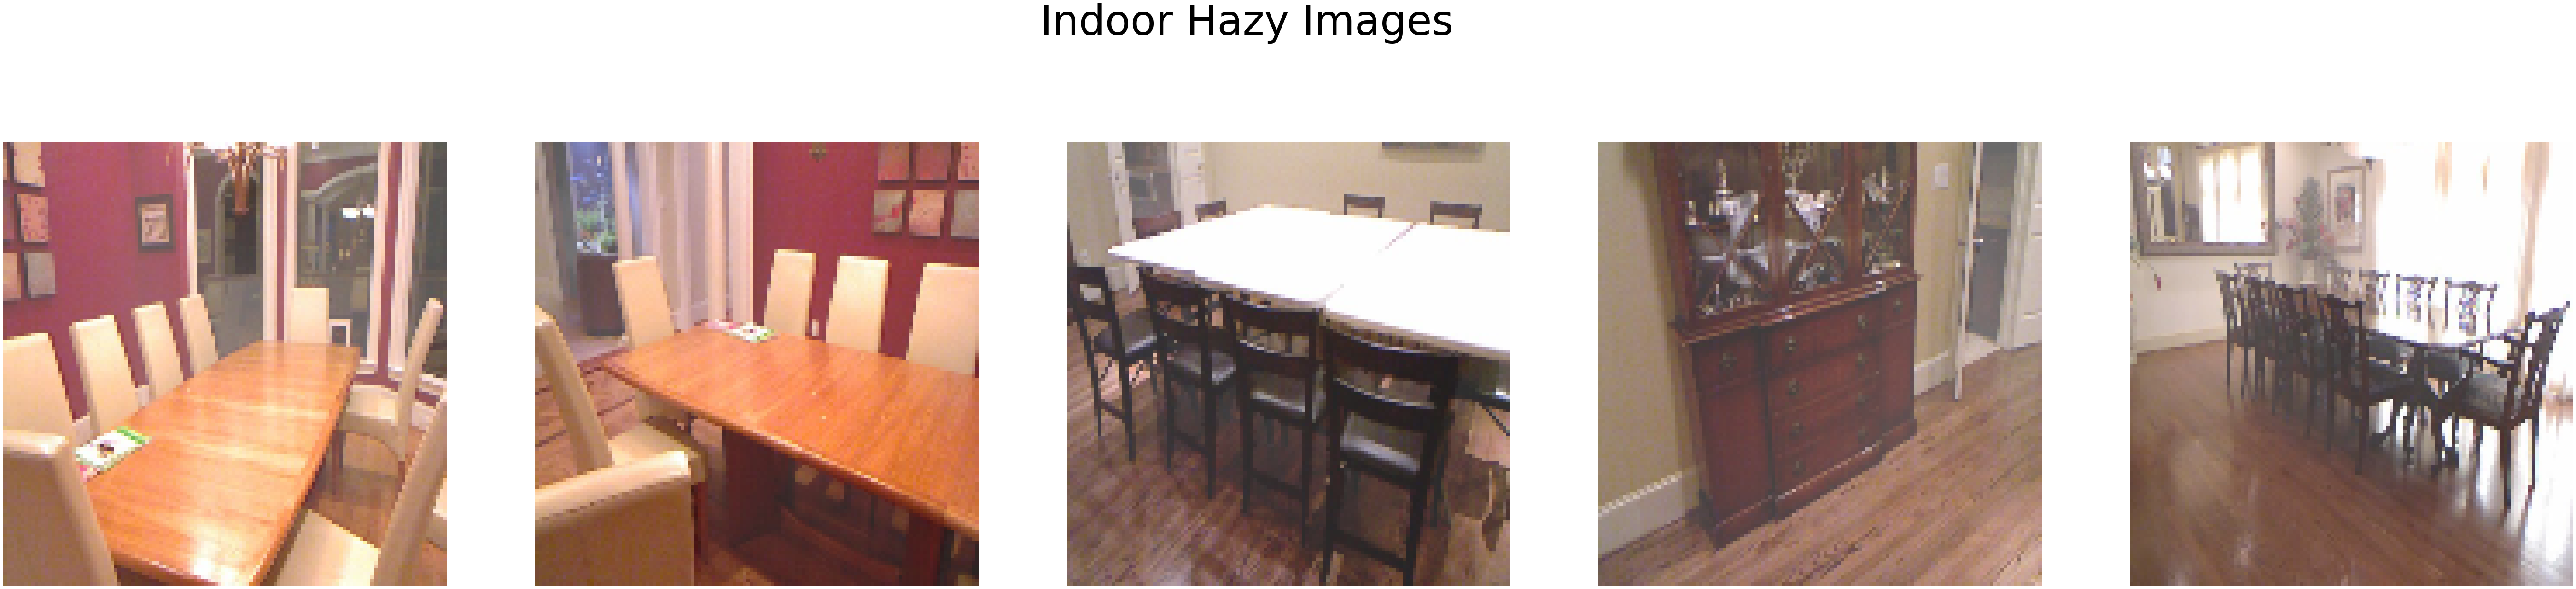

In [63]:
# Display 5 Hazy Images

figure = plt.figure()
num_of_images = 5
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(images_did[index*10].numpy().transpose(1, 2, 0))
plt.suptitle('Indoor Hazy Images', fontsize=90)
plt.subplots_adjust(top=0.95)

<Figure size 432x288 with 0 Axes>

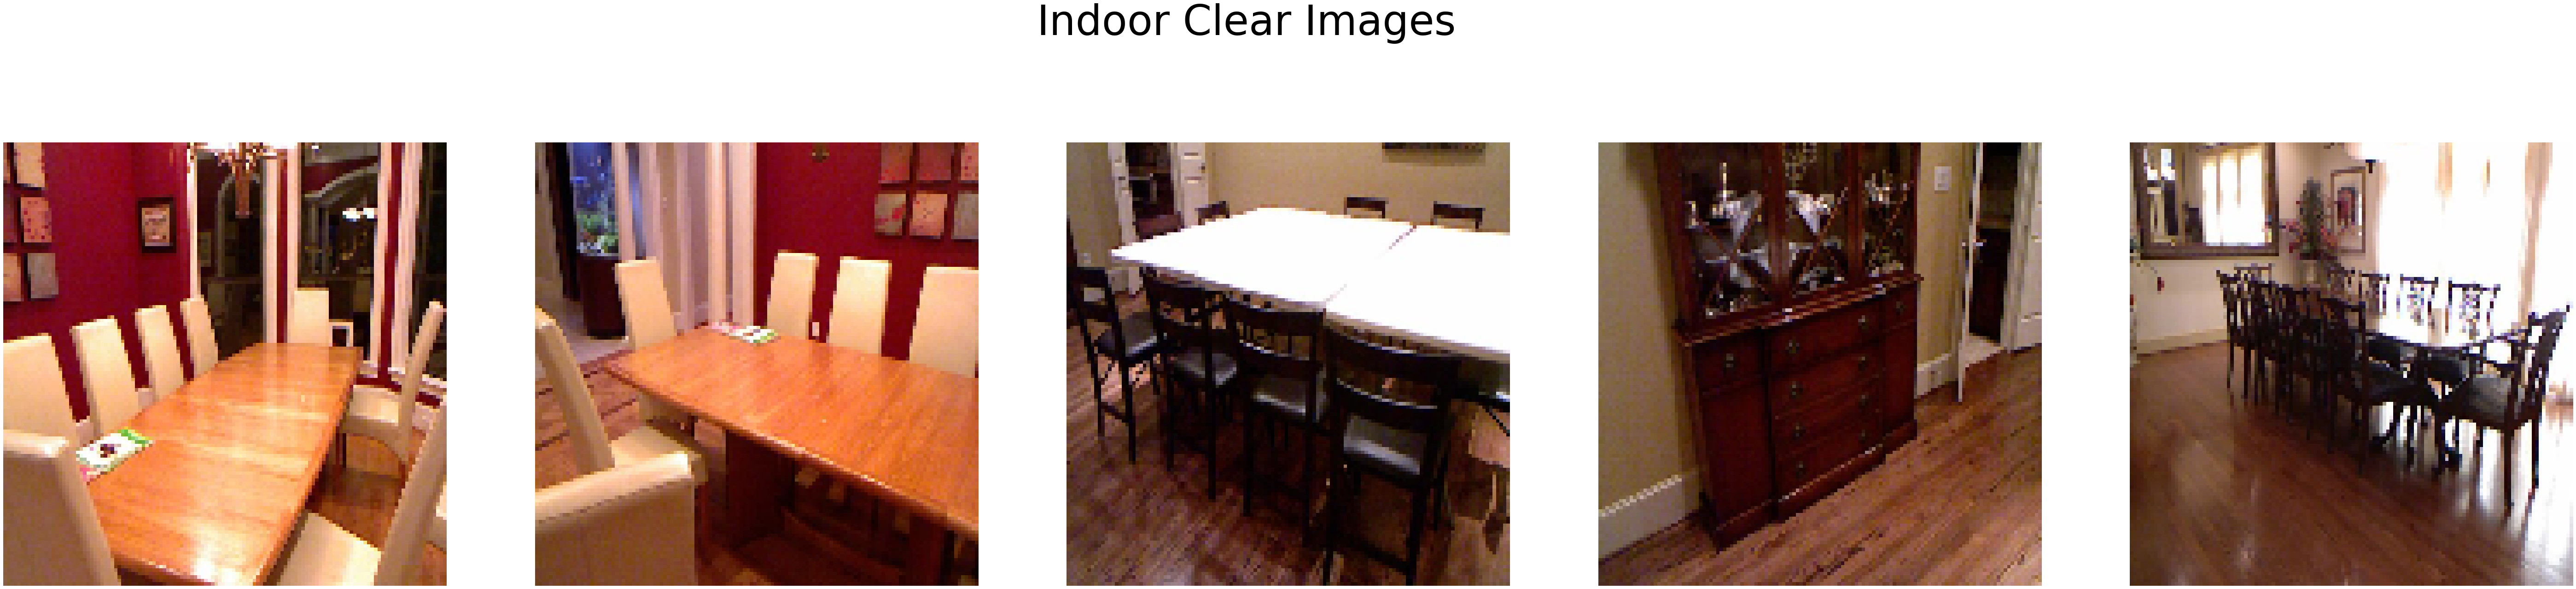

In [64]:
# Display 5 corresponding Clear Images

figure = plt.figure()
num_of_images = 5
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(masks_did[index*10].numpy().transpose(1, 2, 0))
plt.suptitle('Indoor Clear Images', fontsize=90)
plt.subplots_adjust(top=0.95)

In [65]:
dataiter = iter(testloader_id)
images_fid, masks_fid = dataiter.next()

print(type(images_fid))
print(type(masks_fid))
print(images_fid.shape)
print(masks_fid.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


In [66]:
best_model.eval()

with torch.no_grad():
  images_fid = images_fid.to(device)
  best_model = best_model.to(device)
  pred_masks_fid = best_model(images_fid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

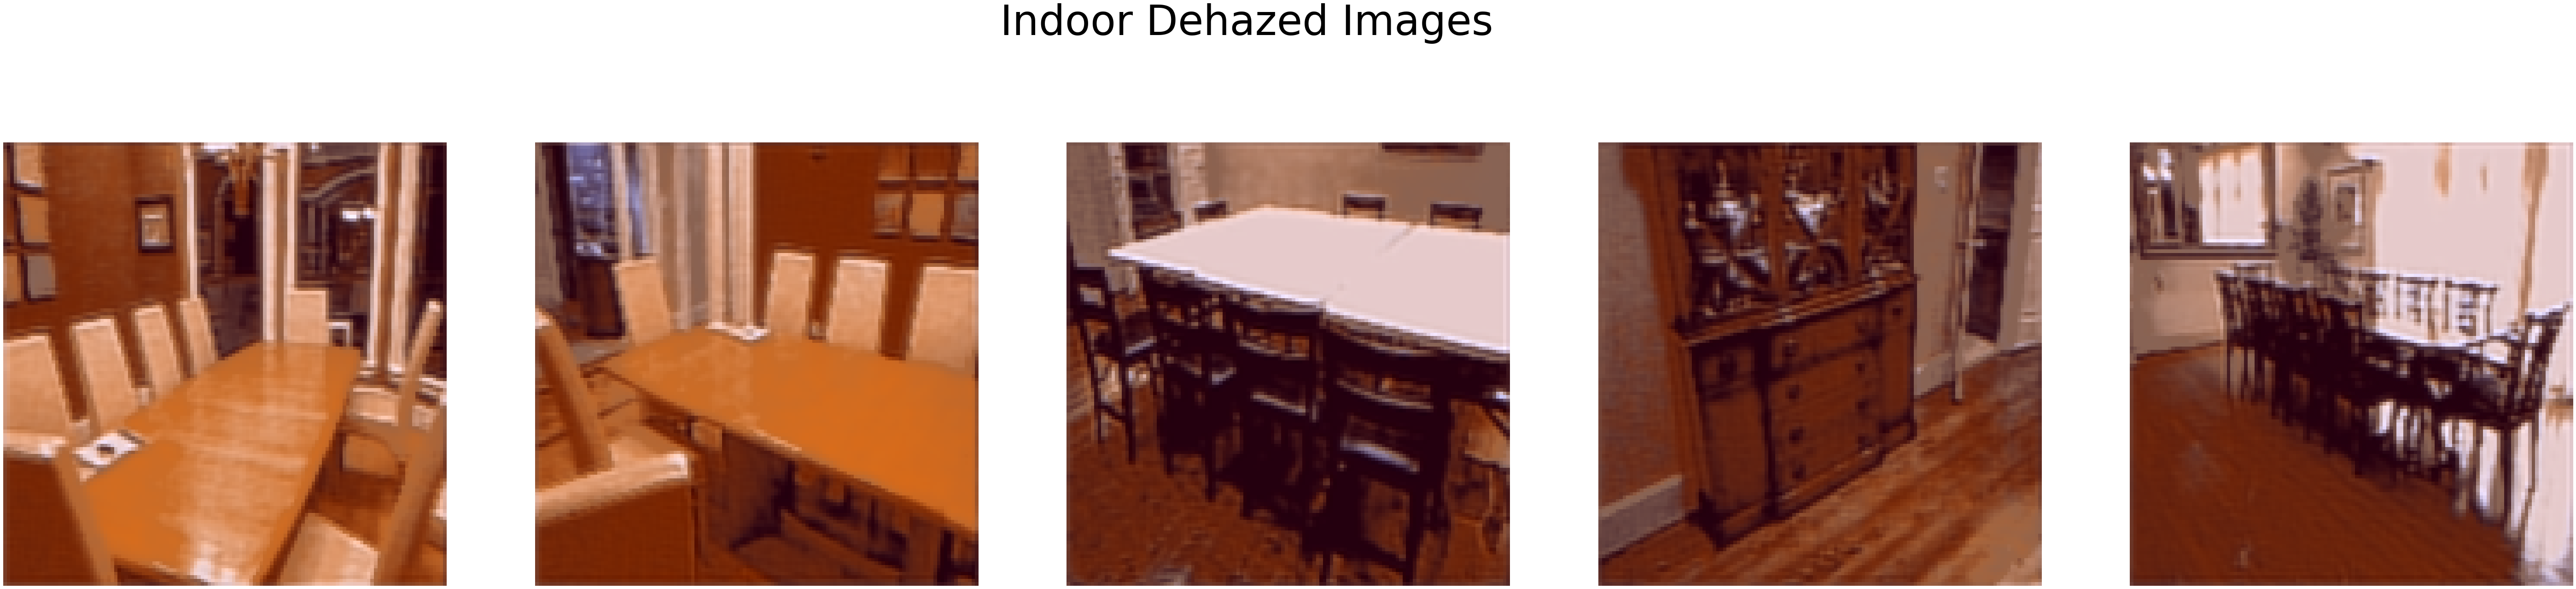

In [67]:
# Display 5 corresponding Dehazed Images

figure = plt.figure()
num_of_images = 5
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(pred_masks_fid[index*10].cpu().numpy().transpose(1, 2, 0))
plt.suptitle('Indoor Dehazed Images', fontsize=90)
plt.subplots_adjust(top=0.95)

### SOTS Outdoor

In [68]:
best_model = InvolutionUNet(enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=3, retain_dim=False, out_sz=(128,128))

best_ckp = torch.load('/content/drive/MyDrive/CV_Project/CheckPoints_U/r3/unet-13.pt')

best_model.load_state_dict(best_ckp['model'])

<All keys matched successfully>

In [69]:
test_loss_od, test_ssim_od, test_psnr_od = test_epoch(best_model, testloader_od, criterion, optimizer, lr_scheduler, phase='test') 
print()
print(f'Test loss SOTS Outdoor: {test_loss_od}, Test SSIM SOTS Outdoor: {test_ssim_od}, Test PSNR SOTS Outdoor: {test_psnr_od}')
print()


Test loss SOTS Outdoor: -5.187748432159424, Test SSIM SOTS Outdoor: 0.5790352467598954, Test PSNR SOTS Outdoor: 17.787032274695918



In [70]:
dataiter = iter(testloader_od_display)
images_dod, masks_dod = dataiter.next()

print(type(images_dod))
print(type(masks_dod))
print(images_dod.shape)
print(masks_dod.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


<Figure size 432x288 with 0 Axes>

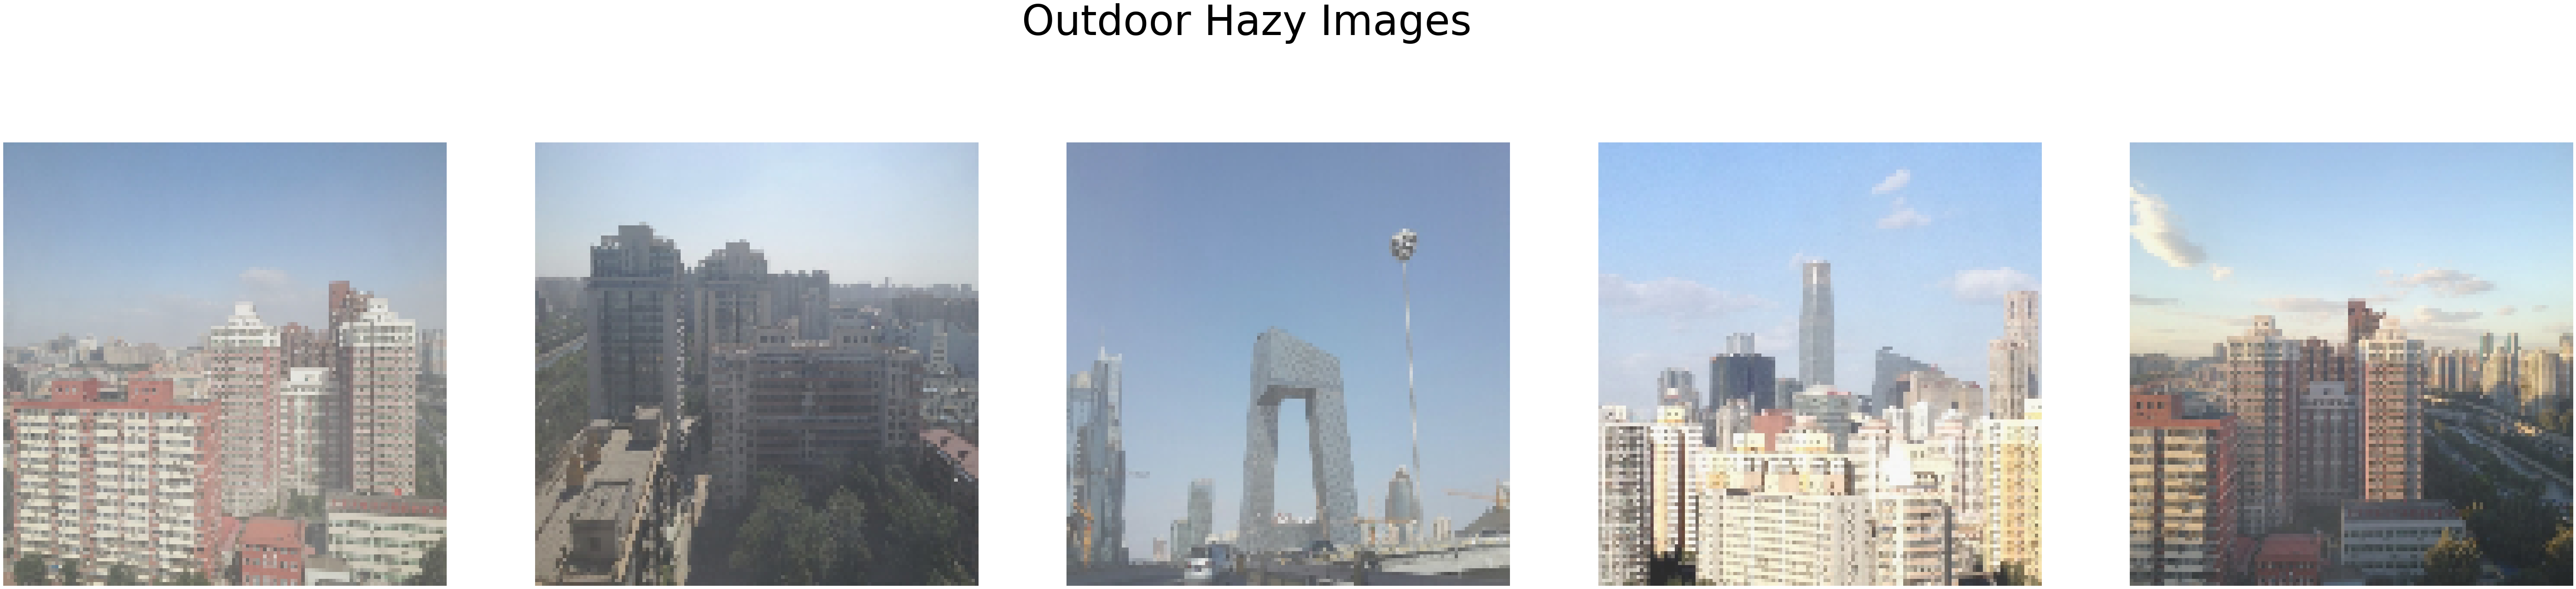

In [71]:
# Display 5 Hazy Images

figure = plt.figure()
num_of_images = 5
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(images_dod[index].numpy().transpose(1, 2, 0))
plt.suptitle('Outdoor Hazy Images', fontsize=90)
plt.subplots_adjust(top=0.95)

<Figure size 432x288 with 0 Axes>

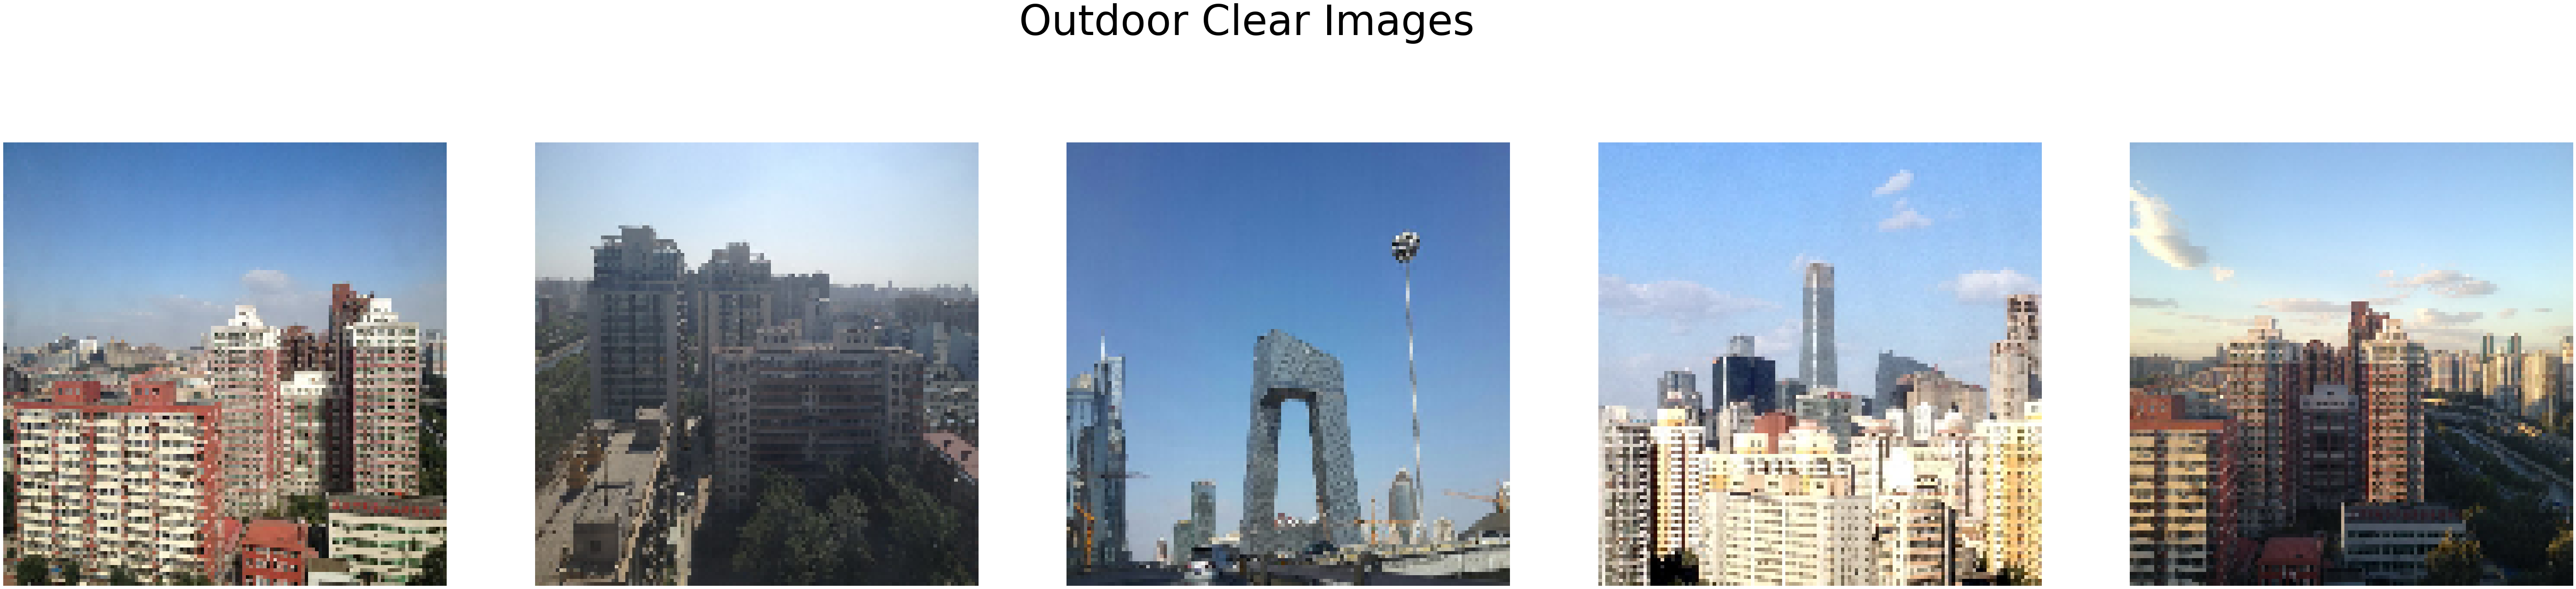

In [72]:
# Display 5 corresponding Clear Images

figure = plt.figure()
num_of_images = 5
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(masks_dod[index].numpy().transpose(1, 2, 0))
plt.suptitle('Outdoor Clear Images', fontsize=90)
plt.subplots_adjust(top=0.95)

In [73]:
dataiter = iter(testloader_od)
images_fod, masks_fod = dataiter.next()

print(type(images_fod))
print(type(masks_fod))
print(images_fod.shape)
print(masks_fod.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


In [74]:
best_model.eval()

with torch.no_grad():
  images_fod = images_fod.to(device)
  best_model = best_model.to(device)
  pred_masks_fod = best_model(images_fod)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

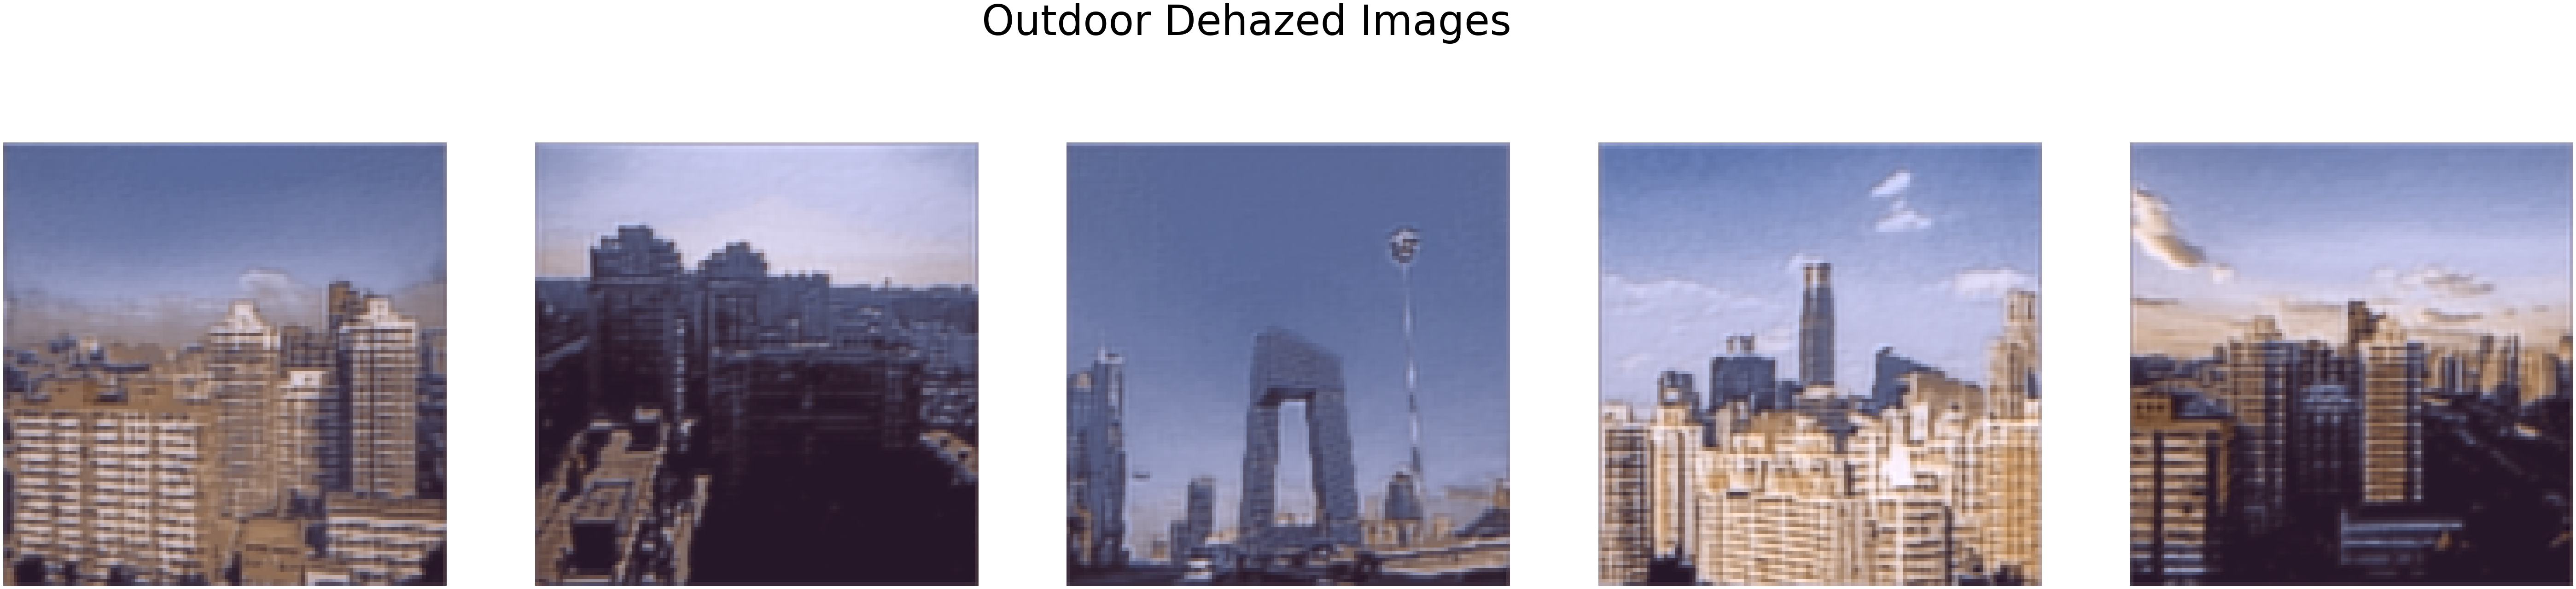

In [75]:
# Display 5 corresponding Dehazed Images

figure = plt.figure()
num_of_images = 5
plt.figure(figsize=(100,50))
for index in range(0, num_of_images):
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(pred_masks_fod[index].cpu().numpy().transpose(1, 2, 0))
plt.suptitle('Outdoor Dehazed Images', fontsize=90)
plt.subplots_adjust(top=0.95)